# Value at Risk & Conditional Value at Risk in Monte Carlo Simulation
## Takao Oba
#### Assisted by quantpy

##### Value at Risk (VaR) is a measure of the risk of an investment. It represents the maximum loss that an investment could experience with a certain level of confidence over a given time horizon. For example, a VaR of  100,000 at 95% confidence over a one-week horizon means that the investment has a 5% probability of losing more than \$100,000 over the next week.

##### Conditional Value at Risk (CVaR), also known as Expected Shortfall (ES), is a measure of the expected loss of an investment beyond a certain level of loss, such as the VaR. It represents the average loss that an investment could experience beyond the VaR threshold. For example, if the VaR of an investment is  100,000 dollars at 95% confidence over a one-week horizon, and the CVaR is 50,000 dollars, this means that the investment has a 5% probability of losing more than 100,000 dollars over the next week, and that the average loss beyond this threshold is expected to be 50,000 dollars.

In [1]:
# importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr

import yfinance as yfin
yfin.pdr_override()

In [2]:
# importing the data
def get_data(stocks, start, end): # return mean return and covariance matrix
    stockData = pdr.get_data_yahoo(stocks, start, end) # getting stock data
    stockData = stockData['Close'] # choose only close price
    returns = stockData.pct_change() # daily changes 
    meanReturns = returns.mean() # use returns to compute mean returns
    covMatrix = returns.cov()
    return meanReturns, covMatrix

In [3]:
stocks = ['AAPL', 'MSFT', 'NFLX', 'GOOGL', 'NVDA']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

In [4]:
meanReturns, covMatrix = get_data(stocks, startDate, endDate)
print(meanReturns)

[*********************100%***********************]  5 of 5 completed
AAPL    -0.000459
GOOGL   -0.001477
MSFT    -0.000745
NFLX     0.000790
NVDA    -0.000966
dtype: float64


In [5]:
# weights for portfolio
weights = np.random.random(len(meanReturns))
weights/= np.sum(weights) # normalize by sum of all weights
print(weights)

[0.2931724  0.04137201 0.1765467  0.11234526 0.37656363]


### Monte Carlo Method

In [6]:
# Number of simulations
mc_sims = 100
T = 100 #timeframe in days

# empty arrays that we initialize
meanM = np.full(shape = (T, len(weights)), fill_value = meanReturns)
meanM = meanM.T # transpose

portfolio_sims = np.full(shape =(T, mc_sims), fill_value = 0.0) # so floats can be added


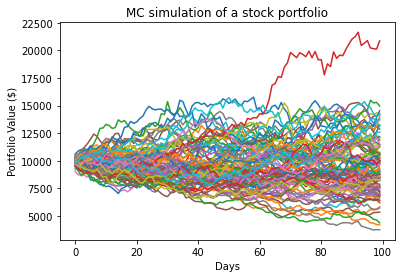

In [7]:
# take a lot of uncorrelated sample data, correlate with cov matrix with use of lower triangular Matrix

initialPortfolio = 10000

L = np.linalg.cholesky(covMatrix)
for m in range(0, mc_sims):
    # MC Loops
    Z = np.random.normal(size = (T, len(weights)))
    
    # lower triangle
    dailyReturns = meanM + np.inner(L,Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolio # cumulative product of daily return

    
plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("MC simulation of a stock portfolio")
plt.show()

# simulated a stock portfolio of 10000 dollars

In [8]:
# Define mcVaR function

def mcVaR(returns, alpha = 5):
    """Input: pandas series of returns
       Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series): # check if input is pandas series
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series")
        
# Define mcCVaR
# expected shortfall once we pass percentile that we are interested in
def mcCVaR(returns, alpha = 5):
    """Input: pandas series of returns
       Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series): # check if input is pandas series
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series")

In [9]:
# portfolio result or last instance in time step

portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha = 5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha = 5)

# print values
print("VaR ${}".format(round(VaR,2)))
print("CVaR ${}".format(round(CVaR,2)))

VaR $4169.69
CVaR $5316.05


In [10]:
print((portResults.mean()))

9506.240996181856


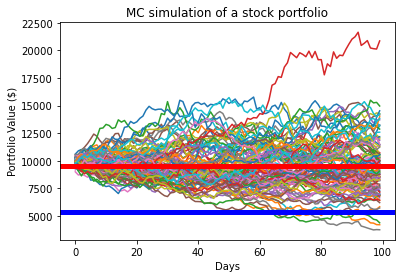

In [11]:
plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("MC simulation of a stock portfolio")

# this horizontal line is for the mean at the end of time stamp
plt.axhline(y = portResults.mean(), color = 'r', linewidth = 5,linestyle = '-')
# VaR at alpha = 5
plt.axhline(y =portResults.mean() - VaR, color = 'b', linewidth = 5,linestyle = '-')
plt.show()

## There is a 5% probability that the investment will lose more than 4169.69 dollars over a certain time horizon.

## Furthermore, with an alpha of 5% and an initial investment of 10,000 dollars in the same situation means that there is a 5% probability that the investment will lose more than the VaR threshold of 4169.69 dollars, and that the expected loss beyond this threshold is 5316.05 dollars.

In [12]:
# try with different alpha values

portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha = 10)
CVaR = initialPortfolio - mcCVaR(portResults, alpha = 10)

# print values
print("VaR ${}".format(round(VaR,2)))
print("CVaR ${}".format(round(CVaR,2)))

VaR $3219.82
CVaR $4504.24


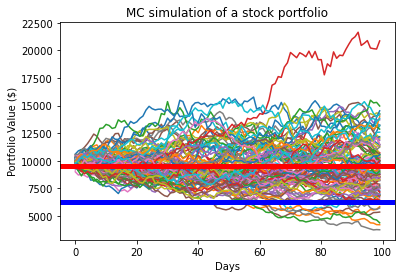

In [13]:
plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("MC simulation of a stock portfolio")

# this horizontal line is for the mean at the end of time stamp
plt.axhline(y = portResults.mean(), color = 'r', linewidth = 5,linestyle = '-')
# VaR at alpha = 10
plt.axhline(y =portResults.mean() - VaR, color = 'b', linewidth = 5,linestyle = '-')
plt.show()
# notice how the blue line moved slightly upwards

## There is a 10% probability that the investment will lose more than 3219.82 dollars over a certain time horizon.

## Furthermore, with an alpha of 10% and an initial investment of 10,000 dollars in the same situation means that there is a 10% probability that the investment will lose more than the VaR threshold of 3219.82 dollars, and that the expected loss beyond this threshold is 4504.24 dollars.

# *In conclusion, I examined the Value at Risk and Conditional Value at Risk in this Monte Carlo simulation.*